# Understanding Activation Functions with MLP on Fashion MNIST

## Code adapted from https://github.com/phlippe/uvadlc_notebooks/tree/master/docs/tutorial_notebooks/tutorial3

By default, PyTorch uses the [Kaiming](https://pytorch.org/docs/stable/nn.init.html#torch.nn.init.kaiming_uniform_) initialization for linear layers optimized for ReLU activations. 

Let's see what happens if we try different initializations.

In [4]:
## Standard libraries
import os
import json
import math
import numpy as np 

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline 
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
import seaborn as sns
sns.set()

## Progress bar
from tqdm.notebook import tqdm

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim

/var/folders/2v/0s_wd0cd04g3xtcdpppg90980000gn/T/ipykernel_59821/3000458389.py:11: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export


In [6]:
device = torch.device("mps") if torch.mps.is_available() else torch.device("cpu")
print("Using device", device)

Using device mps


In [8]:
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available(): # GPU operation have separate seed
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    if torch.mps.is_available():
        torch.mps.manual_seed(seed)

In [31]:
class BaseNetwork(nn.Module): #MLP
    
    def __init__(self, act_fn, input_size=784, num_classes=10, hidden_sizes=[512, 256, 256, 128]):
        super().__init__()
        
        layers = []
        layer_sizes = [input_size] + hidden_sizes
        for layer_index in range(1, len(layer_sizes)):
            layers += [nn.Linear(layer_sizes[layer_index-1], layer_sizes[layer_index]),
                       act_fn]
        layers += [nn.Linear(layer_sizes[-1], num_classes)]
        self.layers = nn.Sequential(*layers) 
        
        self.config = {"act_fn": act_fn.__class__.__name__, "input_size": input_size, "num_classes": num_classes, "hidden_sizes": hidden_sizes} 
        
    def forward(self, x):
        x = x.view(x.shape[0], -1)
        logits = self.layers(x)
        return logits 

In [16]:
import torchvision
from torchvision.datasets import FashionMNIST
from torchvision import transforms

DATASET_PATH = "../data"
# We apply a different normalization to give an expected mean of 0 and a standard deviation of 1 across pixels
transform = transforms.Compose([transforms.ToTensor(), 
                                transforms.Normalize((0.2861,), (0.3530,))])

train_dataset = FashionMNIST(root=DATASET_PATH, train=True, transform=transform, download=True)
train_set, val_set = torch.utils.data.random_split(train_dataset, [50000, 10000])
test_set = FashionMNIST(root=DATASET_PATH, train=False, transform=transform, download=True)

train_loader = data.DataLoader(train_set, batch_size=1024, shuffle=True, drop_last=False)
val_loader = data.DataLoader(val_set, batch_size=1024, shuffle=False, drop_last=False)
test_loader = data.DataLoader(test_set, batch_size=1024, shuffle=False, drop_last=False)

In [20]:
print("Mean", (train_dataset.data.float() / 255.0).mean().item())
print("Std", (train_dataset.data.float() / 255.0).std().item())
imgs, _ = next(iter(train_loader))
print(f"Mean: {imgs.mean().item():5.3f}")
print(f"Standard deviation: {imgs.std().item():5.3f}")
print(f"Maximum: {imgs.max().item():5.3f}")
print(f"Minimum: {imgs.min().item():5.3f}")

Mean 0.2860405743122101
Std 0.3530242443084717
Mean: -0.011
Standard deviation: 0.999
Maximum: 2.022
Minimum: -0.810


Max and min are skewed toward the positive values because FashionMNIST has a lot of black pixels. 

In [23]:
class Identity(nn.Module):
    def forward(self, x):
        return x
    
act_fn_by_name = {
    "tanh": nn.Tanh,
    "relu": nn.ReLU,
    "identity": Identity
}

In [25]:
# Plotting functions

def plot_dists(val_dict, color="C0", xlabel=None, stat="count", use_kde=True):
    columns = len(val_dict)
    fig, ax = plt.subplots(1, columns, figsize=(columns*3, 2.5))
    fig_index = 0
    for key in sorted(val_dict.keys()):
        key_ax = ax[fig_index%columns]
        sns.histplot(val_dict[key], ax=key_ax, color=color, bins=50, stat=stat,
                     kde=use_kde and ((val_dict[key].max()-val_dict[key].min())>1e-8)) # Only plot kde if there is variance
        key_ax.set_title(f"{key} " + (r"(%i $\to$ %i)" % (val_dict[key].shape[1], val_dict[key].shape[0]) if len(val_dict[key].shape)>1 else ""))
        if xlabel is not None:
            key_ax.set_xlabel(xlabel)
        fig_index += 1
    fig.subplots_adjust(wspace=0.4)
    return fig

def visualize_weight_distribution(model, color="C0"):
    weights = {}
    for name, param in model.named_parameters():
        if name.endswith(".bias"):
            continue
        key_name = f"Layer {name.split('.')[1]}"
        weights[key_name] = param.detach().view(-1).cpu().numpy()
    
    ## Plotting
    fig = plot_dists(weights, color=color, xlabel="Weight vals")
    fig.suptitle("Weight distribution", fontsize=14, y=1.05)
    plt.show()
    plt.close() 
    
def visualize_gradients(model, color="C0", print_variance=False):
    """
    Inputs:
        net - Object of class BaseNetwork
        color - Color in which we want to visualize the histogram (for easier separation of activation functions)
    """
    model.eval()
    small_loader = data.DataLoader(train_set, batch_size=1024, shuffle=False)
    imgs, labels = next(iter(small_loader))
    imgs, labels = imgs.to(device), labels.to(device)
    
    # Pass one batch through the network, and calculate the gradients for the weights
    model.zero_grad()
    preds = model(imgs)
    loss = F.cross_entropy(preds, labels) # Same as nn.CrossEntropyLoss, but as a function instead of module
    loss.backward()
    # We limit our visualization to the weight parameters and exclude the bias to reduce the number of plots
    grads = {name: params.grad.view(-1).cpu().clone().numpy() for name, params in model.named_parameters() if "weight" in name}
    model.zero_grad()
    
    ## Plotting
    fig = plot_dists(grads, color=color, xlabel="Grad magnitude")
    fig.suptitle("Gradient distribution", fontsize=14, y=1.05)
    plt.show()
    plt.close() 
    
    if print_variance:
        for key in sorted(grads.keys()):
            print(f"{key} - Variance: {np.var(grads[key])}")

def visualize_activations(model, color="C0", print_variance=False):
    model.eval()
    small_loader = data.DataLoader(train_set, batch_size=1024, shuffle=False)
    imgs, labels = next(iter(small_loader))
    imgs, labels = imgs.to(device), labels.to(device)
    
    # Pass one batch through the network, and calculate the gradients for the weights
    feats = imgs.view(imgs.shape[0], -1)
    activations = {}
    with torch.no_grad():
        for layer_index, layer in enumerate(model.layers):
            feats = layer(feats)
            if isinstance(layer, nn.Linear):
                activations[f"Layer {layer_index}"] = feats.view(-1).detach().cpu().numpy()
    
    ## Plotting
    fig = plot_dists(activations, color=color, stat="density", xlabel="Activation vals")
    fig.suptitle("Activation distribution", fontsize=14, y=1.05)
    plt.show()
    plt.close() 
    
    if print_variance:
        for key in sorted(activations.keys()):
            print(f"{key} - Variance: {np.var(activations[key])}")

* Two desirable properties
    * The variance of the input should be propagated through the model to the last layer
    * Similarly, we want a gradient distribution with equal variance across layers. Is this gradient wrt nodes or edges?

In [33]:
model = BaseNetwork(act_fn=Identity()).to(device)

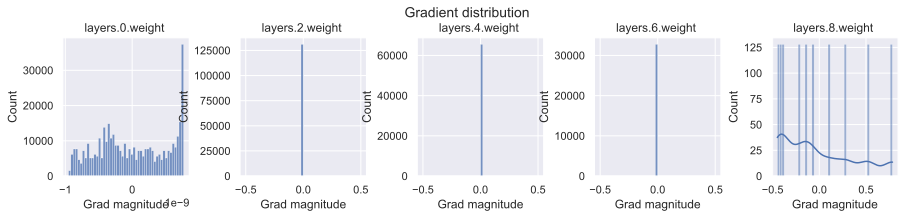

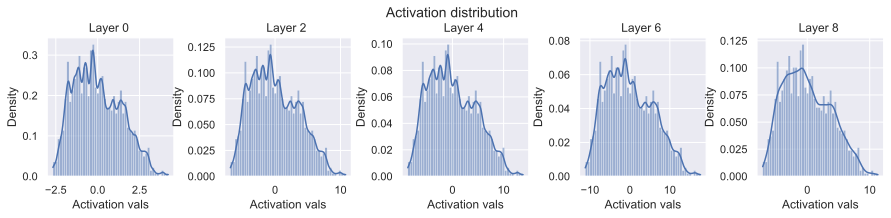

Layer 0 - Variance: 1.9610477685928345
Layer 2 - Variance: 12.851933479309082
Layer 4 - Variance: 21.056602478027344
Layer 6 - Variance: 34.499141693115234
Layer 8 - Variance: 14.130846977233887


In [43]:
def const_init(model, c=0.0):
    for name, param in model.named_parameters():
        # param.data is a torch.Tensor object
        param.data.fill_(c)

const_init(model, c=0.005)
visualize_gradients(model)
visualize_activations(model, print_variance=True)

- Other 3 layers have the same gradient that's close to 0. Why?
- Having the same gradient for parameters that have been initialized with the same values means that we will always have the same value for those parameters. This reduces ESS and effectiveness of weights.

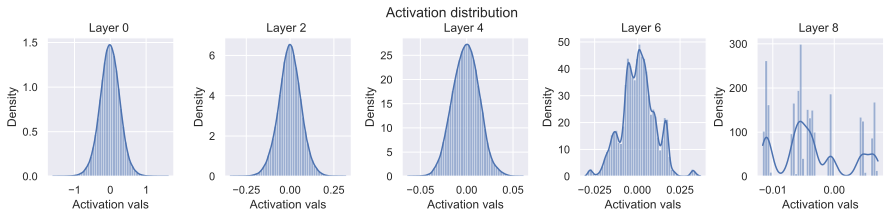

Layer 0 - Variance: 0.07945913821458817
Layer 2 - Variance: 0.004161251243203878
Layer 4 - Variance: 0.00020410331489983946
Layer 6 - Variance: 9.642600343795493e-05
Layer 8 - Variance: 3.0392076951102354e-05


In [48]:
# Activations vanish
def var_init(model, std=0.01):
    for name, param in model.named_parameters():
        param.data.normal_(std=std)
        
var_init(model, std=0.01)
visualize_activations(model, print_variance=True)

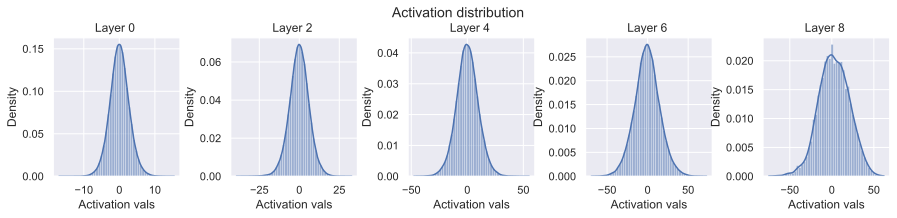

Layer 0 - Variance: 7.421765327453613
Layer 2 - Variance: 37.8360481262207
Layer 4 - Variance: 94.69681549072266
Layer 6 - Variance: 241.3228302001953
Layer 8 - Variance: 335.02349853515625


In [50]:
# Activations explode
var_init(model, std=0.1)
visualize_activations(model, print_variance=True)

* Why do activations vanish/explode? Connection to vanishing/exploding gradients? Is vanishing/exploding gradients reference to nodes or edges?

Suppose now we want two conditions
1. The mean of the activations should be zero
2. The variance of the activations should stay the same across every layer
We have the following relation:
$\operatorname{Var}(y_i) = \operatorname{Var}(\sum_j w_{ij}x_j) = \sigma_x^2 = \sigma_x^2 d_{x} \operatorname{Var}(w_{ij})$, which gives
$\operatorname{Var}(w_{ij}) = \frac{1}{d_{x}}$

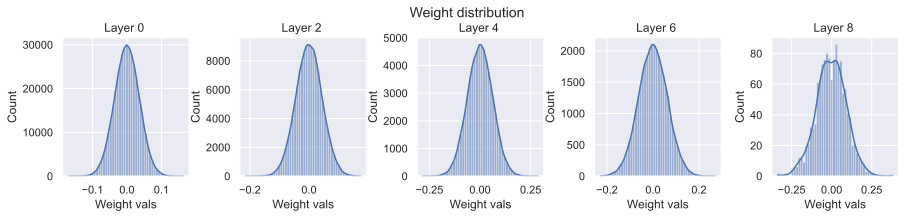

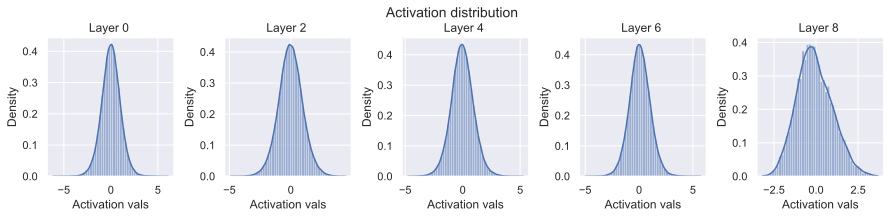

Layer 0 - Variance: 0.9998260140419006
Layer 2 - Variance: 0.9666623473167419
Layer 4 - Variance: 0.9365491271018982
Layer 6 - Variance: 0.93317711353302
Layer 8 - Variance: 1.103977084159851


In [60]:
def equal_var_init(model):
    for name, param in model.named_parameters():
        if name.endswith(".bias"):
            param.data.fill_(0)
        else:
            param.data.normal_(std=1.0/math.sqrt(param.shape[1]))
        
equal_var_init(model)
visualize_weight_distribution(model)
visualize_activations(model, print_variance=True)

Looking at backpropagation, if we wants the variance of the gradients wrt $x_j$ to be the same as that wrt $y_i$, we can repeat the above exercise to get

$\operatorname{Var}(w_{ij}) = \frac{1}{d_{y}}$

A compromise here leads us to the well-known Xavier initialization 

$$W \sim \mathcal{N}\left(0, \frac{2}{d_x + d_y}\right)$$

For a uniform distribution, we would get 

$$W \sim U\left(-\sqrt{\frac{6}{d_x + d_y}}, \sqrt{\frac{6}{d_x + d_y}}\right)$$

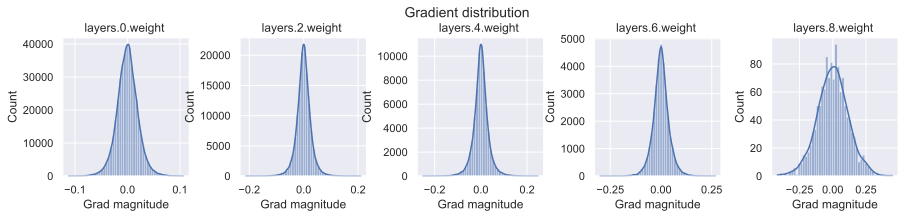

layers.0.weight - Variance: 0.0003980618785135448
layers.2.weight - Variance: 0.0007151510217227042
layers.4.weight - Variance: 0.001050733495503664
layers.6.weight - Variance: 0.001553214737214148
layers.8.weight - Variance: 0.013713772408664227


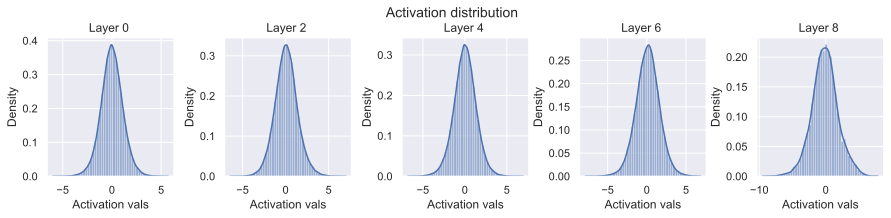

Layer 0 - Variance: 1.2430658340454102
Layer 2 - Variance: 1.7204127311706543
Layer 4 - Variance: 1.750753402709961
Layer 6 - Variance: 2.2457287311553955
Layer 8 - Variance: 3.9275734424591064


In [77]:
def xavier_init(model):
    for name, param in model.named_parameters():
        if name.endswith(".bias"):
            param.data.fill_(0)
        else:
            bound = math.sqrt(6)/math.sqrt(param.shape[0]+param.shape[1])
            param.data.uniform_(-bound, bound)
        
xavier_init(model)
visualize_gradients(model, print_variance=True)
visualize_activations(model, print_variance=True)

Large difference at the last layer due to difference in input and output dimensions. 

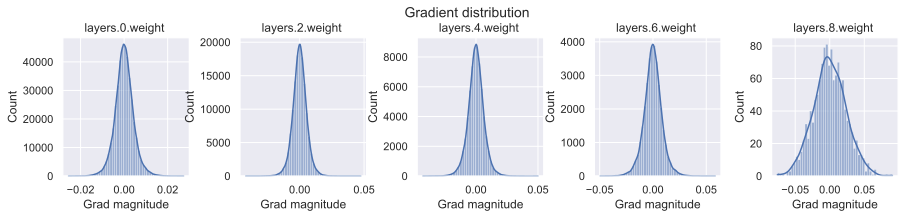

layers.0.weight - Variance: 1.8067115888698027e-05
layers.2.weight - Variance: 2.927375680883415e-05
layers.4.weight - Variance: 4.002633795607835e-05
layers.6.weight - Variance: 7.055352762108669e-05
layers.8.weight - Variance: 0.0005614307010546327


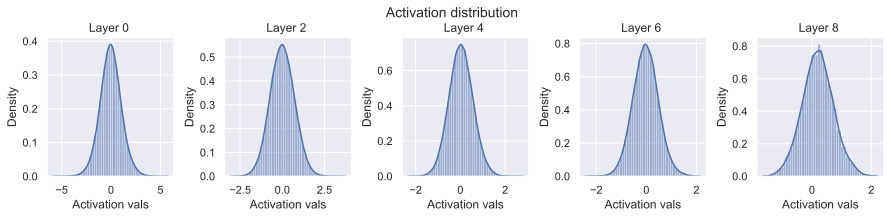

Layer 0 - Variance: 1.1763725280761719
Layer 2 - Variance: 0.5196427702903748
Layer 4 - Variance: 0.2908470630645752
Layer 6 - Variance: 0.2653302848339081
Layer 8 - Variance: 0.27828460931777954


In [97]:
model = BaseNetwork(act_fn=nn.Tanh()).to(device)
xavier_init(model)
visualize_gradients(model, print_variance=True)
visualize_activations(model, print_variance=True)

While the variance decreases over depth, our activation distribution becomes more focused on the low values, where the tanh activation function follows a more linear trend. Since we know that this initialization is stable for the identity activation, we can conclude that the Xavier initialization works well for Tanh networks.

For ReLU, we have

$\operatorname{Var}(w_{ij}x_j) = \mathbb{E}(w_{ij}^2)\mathbb{E}(x_{j}^2) - \mathbb{E}(w_{ij})^2\mathbb{E}(x_{j})^2 = \operatorname{Var}(w_{ij})\mathbb{E}(x_{j}^2)$

Now taking $x_j$ as the post-ReLU output of the previous layer, we get that $\mathbb{E}(x^2) = \frac{1}{2}\operatorname{Var}(\tilde{y}),$ where $\tilde{y}$ is the pre-ReLU activations of the previous layer. 

Hence, our variance is now $\frac{2}{d_x}$, which gives us the Kainming initialization. In their paper, they argue that using $d_x$ or $d_y$ both lead to stable gradients throughout the network

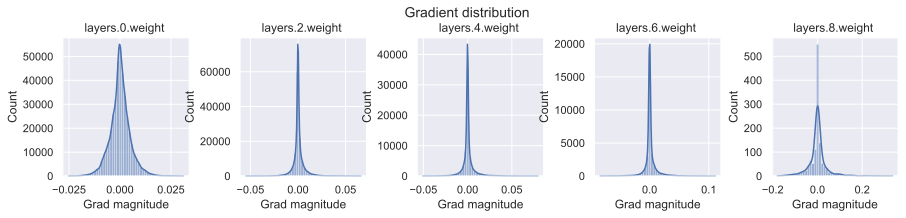

layers.0.weight - Variance: 2.4794033379293978e-05
layers.2.weight - Variance: 3.255133924540132e-05
layers.4.weight - Variance: 3.990222830907442e-05
layers.6.weight - Variance: 0.00010214715439360589
layers.8.weight - Variance: 0.0017749087419360876


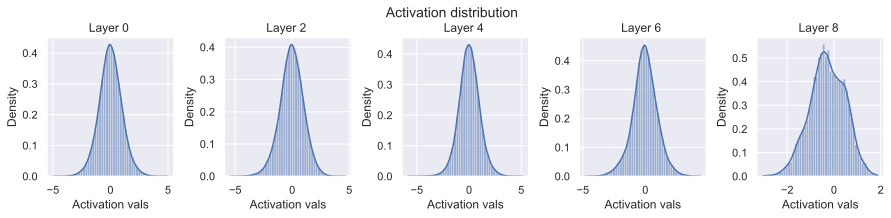

Layer 0 - Variance: 0.9974047541618347
Layer 2 - Variance: 1.0750535726547241
Layer 4 - Variance: 0.9781564474105835
Layer 6 - Variance: 0.9940789341926575
Layer 8 - Variance: 0.5704149007797241


In [100]:
def kaiming_init(model):
    for name, param in model.named_parameters():
        if name.endswith(".bias"):
            param.data.fill_(0)
        elif name.startswith("layers.0"): # The first layer does not have ReLU applied on its input
            param.data.normal_(0, 1/math.sqrt(param.shape[1]))
        else:
            param.data.normal_(0, math.sqrt(2)/math.sqrt(param.shape[1]))

model = BaseNetwork(act_fn=nn.ReLU()).to(device)
kaiming_init(model)
visualize_gradients(model, print_variance=True)
visualize_activations(model, print_variance=True)

Note that for Leaky-ReLU etc., we have to slightly adjust the factor of  in the variance as half of the values are not set to zero anymore. PyTorch provides a function to calculate this factor for many activation functions, see [torch.nn.init.calculate_gain](https://pytorch.org/docs/stable/nn.init.html#torch.nn.init.calculate_gain)